In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.util import random_rotation, find_permutation

# Specify whether or not to save figures
save_figures = True

In [3]:
# Set the parameters of the HMM
T = 200    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [4]:
# Make an LDS with the somewhat interesting dynamics parameters
true_lds = ssm.LDS(N, D, emissions="gaussian")
A0 = .99 * random_rotation(D, theta=np.pi/20)
# S = (1 + 3 * npr.rand(D))
S = np.arange(1, D+1)
R = np.linalg.svd(npr.randn(D, D))[0] * S
A = R.dot(A0).dot(np.linalg.inv(R))
b = npr.randn(D)
true_lds.dynamics.As[0] = A
true_lds.dynamics.bs[0] = b
_, x, y = true_lds.sample(T)

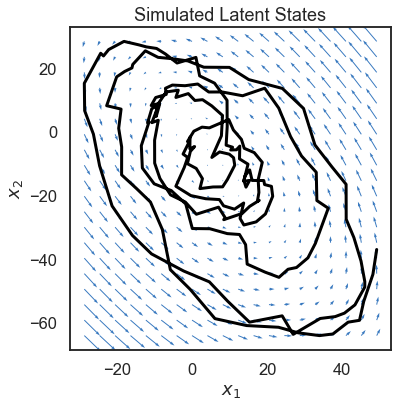

In [5]:
# Plot the dynamics vector field
xmins = x.min(axis=0)
xmaxs = x.max(axis=0)
npts = 20
true_lds.dynamics.As[0] = A
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))
XY = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
dx = XY.dot(A.T) + b - XY

plt.figure(figsize=(6, 6))
plt.quiver(XX, YY, dx[:,0], dx[:,1], color=colors[0])
plt.plot(x[:,0], x[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_1.pdf")

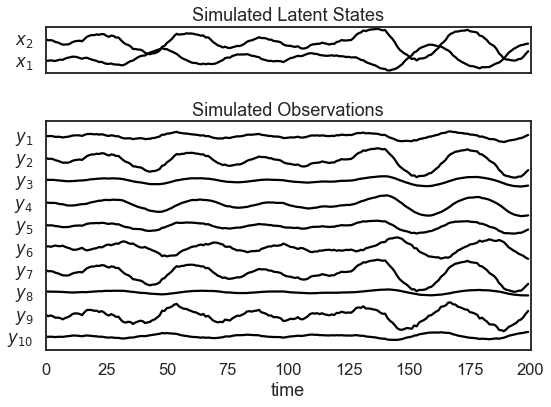

In [6]:
# Plot the dynamics vector field
plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, N/D))

# Plot the continuous latent states
lim = abs(x).max()
plt.subplot(gs[0])
for d in range(D):
    plt.plot(x[:, d] + lim * d, '-k')
plt.yticks(np.arange(D) * lim, ["$x_{}$".format(d+1) for d in range(D)])
plt.xticks([])
plt.xlim(0, T)
plt.title("Simulated Latent States")

lim = abs(y).max()
plt.subplot(gs[1])
for n in range(N):
    plt.plot(y[:, n] - lim * n, '-k')
plt.yticks(-np.arange(N) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(N)])
plt.xlabel("time")
plt.xlim(0, T)

plt.title("Simulated Observations")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_2.pdf")

In [7]:
print("Fitting LDS with SVI")

# Create the model and initialize its parameters
lds = ssm.LDS(N, D, emissions="gaussian_orthog")
lds.initialize(y)

# Create a variational posterior
q_mf = SLDSMeanFieldVariationalPosterior(lds, y)
q_mf_elbos = lds.fit(q_mf, y, num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

Fitting LDS with SVI
Initializing with an ARHMM using 25 steps of EM.


/Users/Macintosh/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [8]:
# Smooth the data under the variational posterior
q_mf_y = lds.smooth(q_mf_x, y)

In [9]:
print("Fitting LDS with SVI using structured variational posterior")
lds = ssm.LDS(N, D, emissions="gaussian_orthog")
lds.initialize(y)

q_struct = SLDSTriDiagVariationalPosterior(lds, y)
q_struct_elbos = lds.fit(q_struct, y, num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_struct_x = q_struct.mean[0]

# Smooth the data under the variational posterior
q_struct_y = lds.smooth(q_struct_x, y)

Fitting LDS with SVI using structured variational posterior
Initializing with an ARHMM using 25 steps of EM.


/Users/Macintosh/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


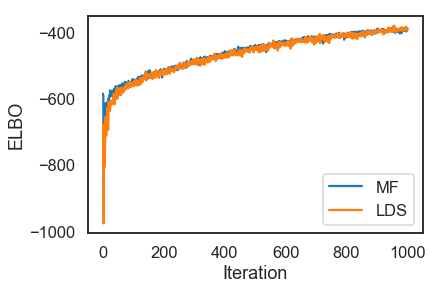

In [10]:
# Plot the ELBOs
plt.plot(q_mf_elbos, label="MF")
plt.plot(q_struct_elbos, label="LDS")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

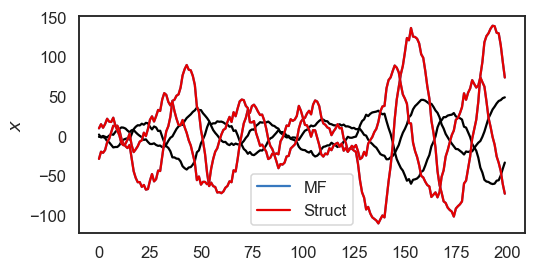

In [11]:
plt.figure(figsize=(8,4))
plt.plot(x + 4 * np.arange(D), '-k')
for d in range(D):
    plt.plot(q_mf_x[:,d] + 4 * d, '-', color=colors[0], label="MF" if d==0 else None)
    plt.plot(q_struct_x[:,d] + 4 * d, '-', color=colors[1], label="Struct" if d==0 else None)
plt.ylabel("$x$")
plt.legend()

Text(0.5, 0, 'time')

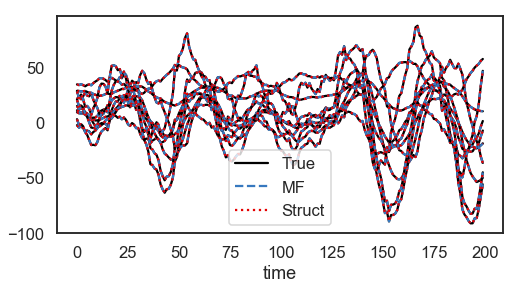

In [12]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
for n in range(N):
    plt.plot(y[:, n] + 4 * n, '-k', label="True" if n == 0 else None)
    plt.plot(q_mf_y[:, n] + 4 * n, '--', color=colors[0], label="MF" if n == 0 else None)
    plt.plot(q_struct_y[:, n] + 4 * n, ':',  color=colors[1], label="Struct" if n == 0 else None)
plt.legend()
plt.xlabel("time")

# Fit an HMM to the LDS states

In [13]:
N_iters = 50
K = 15
hmm = ssm.HMM(K, D, observations="gaussian")
hmm_lls = hmm.fit(x, method="em", num_em_iters=N_iters)
z = hmm.most_likely_states(x)

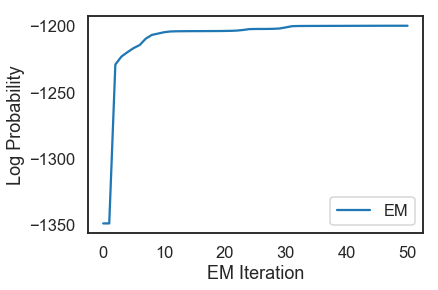

In [14]:
plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")

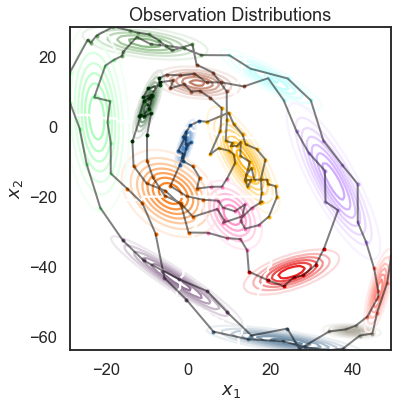

In [15]:
# Plot the observation distributions
from hips.plotting.colormaps import white_to_color_cmap
xmins = x.min(axis=0)
xmaxs = x.max(axis=0)
npts = 100
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))

data = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = hmm.observations.log_likelihoods(data, input, mask, tag)

plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), 
                cmap=white_to_color_cmap(colors[k % len(colors)]))
    plt.plot(x[z==k, 0], x[z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(x[:,0], x[:,1], '-k', lw=2, alpha=.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

plt.tight_layout()

if save_figures:
    plt.savefig("lds_3.pdf")

In [16]:
# Simulate from the HMM fit
smpls = [hmm.sample(T-1, prefix=(z[:1], x[:1])) for _ in range(1)]

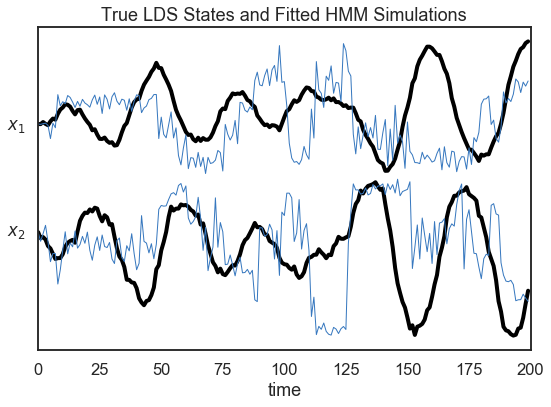

In [17]:
plt.figure(figsize=(8, 6))
lim = abs(x).max()
for d in range(D):
    plt.plot(x[:,d] - d * lim, '-k', lw=4)
    for i, (_, x_smpl) in enumerate(smpls):
        x_smpl = np.concatenate((x[:1], x_smpl))
        plt.plot(x_smpl[:,d] - d*lim, '-', lw=1, color=colors[i])
        
plt.yticks(-np.arange(D) * lim, ["$x_{}$".format(d+1) for d in range(D)])
plt.xlabel("time")
plt.xlim(0, T)
plt.title("True LDS States and Fitted HMM Simulations")

plt.tight_layout()

if save_figures:
    plt.savefig("lds_4.pdf")

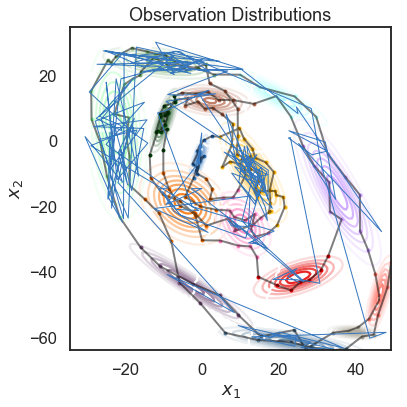

In [18]:
# Plot the observation distributions
from hips.plotting.colormaps import white_to_color_cmap
xmins = x.min(axis=0)
xmaxs = x.max(axis=0)
npts = 100
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))

data = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = hmm.observations.log_likelihoods(data, input, mask, tag)

plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), 
                cmap=white_to_color_cmap(colors[k % len(colors)]))
    plt.plot(x[z==k, 0], x[z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(x[:,0], x[:,1], '-k', lw=2, alpha=.5)
for i, (_, x_smpl) in enumerate(smpls):
    x_smpl = np.concatenate((x[:1], x_smpl))
    plt.plot(x_smpl[:,0], x_smpl[:,1], '-', lw=1, color=colors[i])


plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

plt.tight_layout()

if save_figures:
    plt.savefig("lds_5.pdf")

# Simulate Poisson data from an Poisson LDS with the same dynamics

In [19]:
import copy

plds = ssm.LDS(N, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
plds.dynamics.params = copy.deepcopy(true_lds.dynamics.params)
plds.emissions.ds = 0 * np.ones(N)
_, x_plds, y_plds = plds.sample(T)


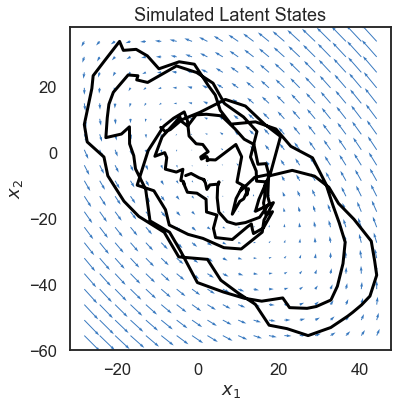

In [20]:
# Plot the dynamics vector field
xmins = x_plds.min(axis=0)
xmaxs = x_plds.max(axis=0)
npts = 20
true_lds.dynamics.As[0] = A
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))
XY = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
dx = XY.dot(A.T) + b - XY

plt.figure(figsize=(6, 6))
plt.quiver(XX, YY, dx[:,0], dx[:,1], color=colors[0])
plt.plot(x_plds[:,0], x_plds[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_6.pdf")

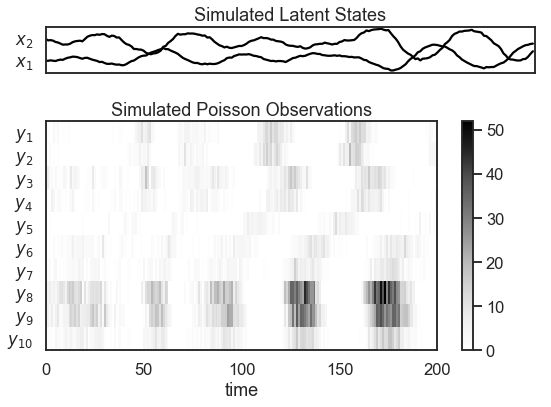

In [21]:
# Plot the dynamics vector field
plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, N/D))

# Plot the continuous latent states
lim = abs(x).max()
plt.subplot(gs[0])
for d in range(D):
    plt.plot(x[:, d] + lim * d, '-k')
plt.yticks(np.arange(D) * lim, ["$x_{}$".format(d+1) for d in range(D)])
plt.xticks([])
plt.xlim(0, T)
plt.title("Simulated Latent States")

lim = abs(y).max()
plt.subplot(gs[1])
plt.imshow(y_plds.T, cmap="Greys", aspect="auto")
plt.yticks(np.arange(N), ["$y_{{ {} }}$".format(n+1) for n in range(N)])
plt.xlabel("time")
plt.xlim(0, T)
plt.title("Simulated Poisson Observations")
plt.colorbar()

plt.tight_layout()

if save_figures:
    plt.savefig("lds_7.pdf")